# NOTEBOOK 3: NONLINEAR OPTIMIZATION FOR y ≥ 77%
## Use nonlinear constrained optimization to find F1-F15 values achieving efficiency ≥ 77%

In [1]:
# Cell 1: Import Libraries
import numpy as np
import pandas as pd
from scipy.optimize import minimize, differential_evolution, dual_annealing, basinhopping
import pickle
import json
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

print("🎯 NONLINEAR OPTIMIZATION FOR CEMENT PLANT EFFICIENCY ≥ 77%")
print("=" * 65)

🎯 NONLINEAR OPTIMIZATION FOR CEMENT PLANT EFFICIENCY ≥ 77%


In [2]:
# Cell 2: Load Nonlinear Model and Data
try:
    # Load cleaned data for bounds
    df = pd.read_csv('cleaned_cement_data.csv')
    print("✅ Loaded cleaned_cement_data.csv")
    
    # Load trained nonlinear model
    with open('best_nonlinear_model.pkl', 'rb') as f:
        model = pickle.load(f)
    print("✅ Loaded best_nonlinear_model.pkl")
    
    # Load model metadata
    with open('nonlinear_model_data.json', 'r') as f:
        model_data = json.load(f)
    print("✅ Loaded nonlinear_model_data.json")
    
    # Load scaler if needed
    scaler = None
    if model_data['uses_scaled_features']:
        with open('feature_scaler.pkl', 'rb') as f:
            scaler = pickle.load(f)
        print("✅ Loaded feature_scaler.pkl")
    
except FileNotFoundError as e:
    print(f"❌ Required file not found: {e}")
    print("Please run notebooks 01 and 02 first!")
    raise

# Extract information
feature_names = model_data['feature_names']
model_name = model_data['model_name']
test_r2 = model_data['test_r2']
uses_scaling = model_data['uses_scaled_features']

print(f"\n📊 Model Information:")
print(f" Model: {model_name}")
print(f" Test R²: {test_r2:.4f}")
print(f" Model Type: Nonlinear")
print(f" Uses Scaling: {'Yes' if uses_scaling else 'No'}")
print(f" Features: {len(feature_names)}")
print(f" Target: y ≥ 77%")

✅ Loaded cleaned_cement_data.csv
✅ Loaded best_nonlinear_model.pkl
✅ Loaded nonlinear_model_data.json
✅ Loaded feature_scaler.pkl

📊 Model Information:
 Model: SVR (RBF Kernel)
 Test R²: 0.9997
 Model Type: Nonlinear
 Uses Scaling: Yes
 Features: 15
 Target: y ≥ 77%


In [3]:
# Define explicit bounds dictionary matching feature_names order
explicit_bounds = {
    'F1': (800, 1200),       # Feed Size
    'F2': (20, 25),          # Product Size
    'F3': (1600, 2000),      # Mill Power Consumption (first)
    'F4': (80, 120),         # Mill Inlet Temperature
    'F5': (85, 95),          # Blending Efficiency
    'F6': (850, 900),        # C5 Temperature
    'F7': (85, 90),          # Heat Recovery Efficiency
    'F8': (4, 6),            # Fuel Flow Rate
    'F9': (8, 12),           # Primary Fuel Flow
    'F10': (800, 1100),      # Secondary Air Temperature
    'F11': (800, 1200),      # Kiln Drive Power
    'F12': (1200, 1400),     # Clinker Inlet Temperature
    'F13': (400, 600),       # Cooling Air Flow
    'F14': (2000, 2500),     # Mill Power Consumption (second)
    'F15': (8, 15),          # Packing Rate
}

print(f"\n📊 FEATURE BOUNDS ANALYSIS:")
print(f"{'Feature':<8} {'Min':<12} {'Max':<12} {'Range':<12} {'Mean':<12}")
print("-" * 60)

bounds = []
feature_info = {}

for i, feature in enumerate(feature_names):
    # Use explicit bounds
    min_val, max_val = explicit_bounds[feature]
    range_val = max_val - min_val
    mean_val = df[feature].mean()  # Still using mean from df for prediction testing
    
    bounds.append((min_val, max_val))
    feature_info[feature] = {
        'min': min_val,
        'max': max_val,
        'range': range_val,
        'mean': mean_val
    }
    
    print(f"{feature:<8} {min_val:<12.2f} {max_val:<12.2f} {range_val:<12.2f} {mean_val:<12.2f}")

print(f"\nBounds created for all {len(bounds)} features")


# Define prediction function
def predict_efficiency(x):
    """Predict efficiency from feature vector x"""
    x = np.array(x).reshape(1, -1)
    
    if uses_scaling:
        x_scaled = scaler.transform(x)
        return model.predict(x_scaled)[0]
    else:
        return model.predict(x)[0]

# Test prediction function
test_x = [df[feature].mean() for feature in feature_names]
test_pred = predict_efficiency(test_x)
print(f"\n🧪 Prediction function test:")
print(f" Input: Mean feature values")
print(f" Predicted efficiency: {test_pred:.2f}%")
print(f" ✅ Prediction function working correctly")


📊 FEATURE BOUNDS ANALYSIS:
Feature  Min          Max          Range        Mean        
------------------------------------------------------------
F1       800.00       1200.00      400.00       1096.62     
F2       20.00        25.00        5.00         20.40       
F3       1600.00      2000.00      400.00       1745.18     
F4       80.00        120.00       40.00        115.16      
F5       85.00        95.00        10.00        91.96       
F6       850.00       900.00       50.00        861.55      
F7       85.00        90.00        5.00         87.45       
F8       4.00         6.00         2.00         4.94        
F9       8.00         12.00        4.00         8.72        
F10      800.00       1100.00      300.00       1048.72     
F11      800.00       1200.00      400.00       1073.60     
F12      1200.00      1400.00      200.00       1345.74     
F13      400.00       600.00       200.00       529.94      
F14      2000.00      2500.00      500.00       2193.85  

In [4]:
# Cell 4: Current System Analysis
current_max_y = df['y'].max()
current_mean_y = df['y'].mean()
target_y = 77.0
samples_above_target = (df['y'] >= target_y).sum()

print(f"\n🎯 CURRENT SYSTEM ANALYSIS:")
print(f" Current Mean Efficiency: {current_mean_y:.2f}%")
print(f" Current Max Efficiency: {current_max_y:.2f}%")
print(f" Target Efficiency: {target_y:.2f}%")
print(f" Gap to Target: {target_y - current_max_y:.2f}% points")
print(f" Historical samples ≥{target_y}%: {samples_above_target} out of {len(df)}")

if current_max_y >= target_y:
    print(f" ✅ Target {target_y}% has been achieved historically")
    print(f" 🎯 Goal: Find consistent parameter combination for {target_y}%+")
else:
    print(f" ⚠️ Target {target_y}% exceeds historical maximum")
    print(f" 🎯 Goal: Use nonlinear model to extrapolate beyond historical performance")

# Model capability check
print(f"\n🔮 MODEL CAPABILITY ASSESSMENT:")
print(f" Model Accuracy: R² = {test_r2:.4f}")
print(f" Model Type: {model_name}")
if test_r2 > 0.8:
    print(f" ✅ High accuracy model - reliable for optimization")
elif test_r2 > 0.6:
    print(f" 🟡 Moderate accuracy - optimization results should be validated")
else:
    print(f" ⚠️ Low accuracy - optimization results may be unreliable")


🎯 CURRENT SYSTEM ANALYSIS:
 Current Mean Efficiency: 61.70%
 Current Max Efficiency: 77.00%
 Target Efficiency: 77.00%
 Gap to Target: 0.00% points
 Historical samples ≥77.0%: 1 out of 4320
 ✅ Target 77.0% has been achieved historically
 🎯 Goal: Find consistent parameter combination for 77.0%+

🔮 MODEL CAPABILITY ASSESSMENT:
 Model Accuracy: R² = 0.9997
 Model Type: SVR (RBF Kernel)
 ✅ High accuracy model - reliable for optimization


In [5]:
# Cell 5: Define Optimization Problem
print(f"\n🔧 NONLINEAR OPTIMIZATION PROBLEM SETUP:")
print(f"\nObjective: Maximize predicted_efficiency(F₁, F₂, ..., F₁₅)")
print(f"Constraint: predicted_efficiency(F₁, F₂, ..., F₁₅) ≥ {target_y}%")
print(f"Bounds: F₁ ∈ [{bounds[0][0]:.1f}, {bounds[0][1]:.1f}], ..., F₁₅ ∈ [{bounds[14][0]:.1f}, {bounds[14][1]:.1f}]")
print(f"Model: {model_name} (nonlinear black-box function)")

def objective_function(x):
    """Objective function to minimize (negative efficiency)"""
    try:
        return -predict_efficiency(x)
    except:
        return 1e6  # Large penalty for invalid inputs

def constraint_function(x):
    """Constraint function: efficiency >= target_y"""
    try:
        return predict_efficiency(x) - target_y
    except:
        return -1e6  # Large penalty for invalid inputs

def feasibility_check(x):
    """Check if solution is within bounds"""
    for i, (min_val, max_val) in enumerate(bounds):
        if x[i] < min_val or x[i] > max_val:
            return False
    return True

print(f"\n📐 Optimization Setup:")
print(f" Objective: Minimize -predicted_efficiency(x)")
print(f" Constraint: predicted_efficiency(x) - {target_y} ≥ 0")
print(f" Variables: {len(bounds)} continuous variables (F1-F15)")
print(f" Problem type: Nonlinear constrained optimization")


🔧 NONLINEAR OPTIMIZATION PROBLEM SETUP:

Objective: Maximize predicted_efficiency(F₁, F₂, ..., F₁₅)
Constraint: predicted_efficiency(F₁, F₂, ..., F₁₅) ≥ 77.0%
Bounds: F₁ ∈ [800.0, 1200.0], ..., F₁₅ ∈ [8.0, 15.0]
Model: SVR (RBF Kernel) (nonlinear black-box function)

📐 Optimization Setup:
 Objective: Minimize -predicted_efficiency(x)
 Constraint: predicted_efficiency(x) - 77.0 ≥ 0
 Variables: 15 continuous variables (F1-F15)
 Problem type: Nonlinear constrained optimization


In [6]:
# Cell 6: Method 1 - Constrained Nonlinear Optimization (SLSQP)
print(f"\n🚀 METHOD 1: CONSTRAINED NONLINEAR OPTIMIZATION (SLSQP)")
print("-" * 60)

optimization_results = {}

# Multiple starting points for better global search
starting_points = [
    # Mean values
    [df[feature].mean() for feature in feature_names],
    # Random points within bounds
    [np.random.uniform(bounds[i][0], bounds[i][1]) for i in range(15)],
    [np.random.uniform(bounds[i][0], bounds[i][1]) for i in range(15)],
    # High performance historical point (if available)
    df.loc[df['y'].idxmax(), feature_names].tolist()
]

constraints = [{
    'type': 'ineq',
    'fun': constraint_function
}]

best_slsqp_result = None
best_slsqp_efficiency = -np.inf

print(f"Trying {len(starting_points)} different starting points...")

for i, x0 in enumerate(starting_points):
    try:
        result = minimize(
            objective_function,
            x0,
            method='SLSQP',
            bounds=bounds,
            constraints=constraints,
            options={'maxiter': 1000, 'ftol': 1e-9}
        )
        
        if result.success:
            efficiency = predict_efficiency(result.x)
            if efficiency > best_slsqp_efficiency:
                best_slsqp_efficiency = efficiency
                best_slsqp_result = result
            
            print(f" Start {i+1}: Efficiency = {efficiency:.4f}% {'✅' if efficiency >= target_y else '❌'}")
        else:
            print(f" Start {i+1}: Failed - {result.message}")
            
    except Exception as e:
        print(f" Start {i+1}: Error - {e}")

if best_slsqp_result is not None:
    print(f"\n🎯 SLSQP Best Result:")
    print(f" Efficiency: {best_slsqp_efficiency:.4f}%")
    print(f" Target achieved: {'✅ YES' if best_slsqp_efficiency >= target_y else '❌ NO'}")
    
    optimization_results['SLSQP'] = {
        'x': best_slsqp_result.x,
        'y': best_slsqp_efficiency,
        'success': best_slsqp_efficiency >= target_y,
        'method': 'SLSQP'
    }
else:
    print(f"\n❌ SLSQP failed to find any solution")


🚀 METHOD 1: CONSTRAINED NONLINEAR OPTIMIZATION (SLSQP)
------------------------------------------------------------
Trying 4 different starting points...
 Start 1: Efficiency = 78.0998% ✅
 Start 2: Efficiency = 78.0998% ✅
 Start 3: Efficiency = 78.0998% ✅
 Start 4: Efficiency = 78.0998% ✅

🎯 SLSQP Best Result:
 Efficiency: 78.0998%
 Target achieved: ✅ YES


In [7]:
# Cell 7: Method 2 - Global Optimization Approaches
print(f"\n🚀 METHOD 2: GLOBAL OPTIMIZATION APPROACHES")
print("-" * 50)

# Method 2a: Differential Evolution
print(f"\n🧬 Method 2a: Differential Evolution")
try:
    def constraint_penalty(x):
        """Penalized objective for unconstrained global optimization"""
        efficiency = predict_efficiency(x)
        penalty = 0
        if efficiency < target_y:
            penalty = 1000 * (target_y - efficiency) ** 2
        return -efficiency + penalty
    
    result_de = differential_evolution(
        constraint_penalty,
        bounds,
        maxiter=1000,
        popsize=20,
        seed=42,
        atol=1e-8,
        tol=1e-8
    )
    
    if result_de.success:
        efficiency_de = predict_efficiency(result_de.x)
        print(f" Success: Efficiency = {efficiency_de:.4f}% {'✅' if efficiency_de >= target_y else '❌'}")
        
        optimization_results['Differential Evolution'] = {
            'x': result_de.x,
            'y': efficiency_de,
            'success': efficiency_de >= target_y,
            'method': 'Differential Evolution'
        }
    else:
        print(f" Failed: {result_de.message}")
        
except Exception as e:
    print(f" Error: {e}")

# Method 2b: Dual Annealing
print(f"\n🔥 Method 2b: Dual Annealing")
try:
    result_da = dual_annealing(
        constraint_penalty,
        bounds,
        maxiter=1000,
        seed=42
    )
    
    if result_da.success:
        efficiency_da = predict_efficiency(result_da.x)
        print(f" Success: Efficiency = {efficiency_da:.4f}% {'✅' if efficiency_da >= target_y else '❌'}")
        
        optimization_results['Dual Annealing'] = {
            'x': result_da.x,
            'y': efficiency_da,
            'success': efficiency_da >= target_y,
            'method': 'Dual Annealing'
        }
    else:
        print(f" Failed: {result_da.message}")
        
except Exception as e:
    print(f" Error: {e}")

# Method 2c: Basin Hopping
print(f"\n🏔️ Method 2c: Basin Hopping")
try:
    # Start from best historical point
    x0 = df.loc[df['y'].idxmax(), feature_names].tolist()
    
    result_bh = basinhopping(
        constraint_penalty,
        x0,
        niter=200,
        T=1.0,
        stepsize=0.5,
        minimizer_kwargs={'method': 'L-BFGS-B', 'bounds': bounds},
        seed=42
    )
    
    efficiency_bh = predict_efficiency(result_bh.x)
    print(f" Result: Efficiency = {efficiency_bh:.4f}% {'✅' if efficiency_bh >= target_y else '❌'}")
    
    optimization_results['Basin Hopping'] = {
        'x': result_bh.x,
        'y': efficiency_bh,
        'success': efficiency_bh >= target_y,
        'method': 'Basin Hopping'
    }
        
except Exception as e:
    print(f" Error: {e}")


🚀 METHOD 2: GLOBAL OPTIMIZATION APPROACHES
--------------------------------------------------

🧬 Method 2a: Differential Evolution
 Success: Efficiency = 78.0998% ✅

🔥 Method 2b: Dual Annealing
 Success: Efficiency = 78.0998% ✅

🏔️ Method 2c: Basin Hopping
 Result: Efficiency = 78.0998% ✅


In [8]:
# Cell 8: Method 3 - Advanced Multi-Start Strategy
print(f"\n🚀 METHOD 3: ADVANCED MULTI-START STRATEGY")
print("-" * 50)

# Generate diverse starting points
n_starts = 20
np.random.seed(42)

diverse_starts = []
# Random starts
for _ in range(n_starts//2):
    start = [np.random.uniform(bounds[i][0], bounds[i][1]) for i in range(15)]
    diverse_starts.append(start)

# Perturbed historical good points
top_samples = df.nlargest(n_starts//2, 'y')
for _, row in top_samples.iterrows():
    base = row[feature_names].tolist()
    # Add small random perturbation
    perturbed = []
    for i, val in enumerate(base):
        noise = np.random.normal(0, 0.1 * feature_info[feature_names[i]]['range'])
        new_val = np.clip(val + noise, bounds[i][0], bounds[i][1])
        perturbed.append(new_val)
    diverse_starts.append(perturbed)

print(f"Running {len(diverse_starts)} multi-start optimizations...")

multistart_results = []
successful_runs = 0

for i, x0 in enumerate(diverse_starts):
    try:
        # Use Trust-Constr method for better constraint handling
        result = minimize(
            objective_function,
            x0,
            method='trust-constr',
            bounds=bounds,
            constraints=constraints,
            options={'maxiter': 500}
        )
        
        if result.success and feasibility_check(result.x):
            efficiency = predict_efficiency(result.x)
            multistart_results.append({
                'x': result.x,
                'y': efficiency,
                'success': efficiency >= target_y,
                'run': i+1
            })
            successful_runs += 1
            
            if i < 5:  # Show first few results
                print(f" Run {i+1}: Efficiency = {efficiency:.4f}% {'✅' if efficiency >= target_y else '❌'}")
            
    except:
        continue

print(f" ...")
print(f" Total successful runs: {successful_runs}/{len(diverse_starts)}")

if multistart_results:
    # Find best result
    best_multistart = max(multistart_results, key=lambda x: x['y'])
    print(f"\n🎯 Multi-Start Best Result:")
    print(f" Efficiency: {best_multistart['y']:.4f}%")
    print(f" Target achieved: {'✅ YES' if best_multistart['success'] else '❌ NO'}")
    print(f" From run: {best_multistart['run']}")
    
    optimization_results['Multi-Start'] = {
        'x': best_multistart['x'],
        'y': best_multistart['y'],
        'success': best_multistart['success'],
        'method': 'Multi-Start Trust-Constr'
    }
    
    # Count successful solutions
    successful_solutions = [r for r in multistart_results if r['success']]
    print(f" Solutions achieving target: {len(successful_solutions)}/{successful_runs}")
else:
    print(f" No successful multi-start solutions found")


🚀 METHOD 3: ADVANCED MULTI-START STRATEGY
--------------------------------------------------
Running 20 multi-start optimizations...
 Run 1: Efficiency = 78.0998% ✅
 ...
 Total successful runs: 3/20

🎯 Multi-Start Best Result:
 Efficiency: 78.0998%
 Target achieved: ✅ YES
 From run: 14
 Solutions achieving target: 3/3


In [9]:
# Cell 9: Results Analysis and Best Solution Selection
print(f"\n🏆 OPTIMIZATION RESULTS ANALYSIS:")
print("=" * 60)

if not optimization_results:
    print(f"❌ No successful optimization results found!")
    print(f"This suggests that achieving y ≥ {target_y}% may not be possible with the current model and bounds.")
else:
    # Separate successful and failed solutions
    successful_solutions = {k: v for k, v in optimization_results.items() if v['success']}
    failed_solutions = {k: v for k, v in optimization_results.items() if not v['success']}
    
    print(f"\n📊 SUMMARY:")
    print(f" Methods tested: {len(optimization_results)}")
    print(f" Successful solutions: {len(successful_solutions)}")
    print(f" Failed solutions: {len(failed_solutions)}")
    
    if successful_solutions:
        print(f"\n✅ SUCCESSFUL SOLUTIONS:")
        print(f"{'Method':<25} {'Efficiency':<12} {'Target Met':<12} {'Improvement'}")
        print("-" * 65)
        
        # Find best solution (highest efficiency)
        best_method = max(successful_solutions.keys(), key=lambda k: successful_solutions[k]['y'])
        best_solution = successful_solutions[best_method]
        
        for method, result in successful_solutions.items():
            improvement = result['y'] - current_max_y
            status = "🥇 BEST" if method == best_method else "✅ YES"
            print(f"{method:<25} {result['y']:<12.4f} {status:<12} +{improvement:.4f}%")
        
        print(f"\n🥇 BEST SOLUTION: {best_method}")
        print(f" Achieved Efficiency: {best_solution['y']:.4f}%")
        print(f" Target Achievement: {'✅ YES' if best_solution['y'] >= target_y else '❌ NO'}")
        print(f" Improvement over historical max: +{best_solution['y'] - current_max_y:.4f}% points")
        print(f" Relative improvement: +{((best_solution['y'] - current_max_y) / current_max_y * 100):.2f}%")
        
    else:
        print(f"\n❌ NO SUCCESSFUL SOLUTIONS FOUND")
        print(f"\nThis means that achieving y ≥ {target_y}% is NOT POSSIBLE with:")
        print(f" • Current nonlinear model: {model_name}")
        print(f" • Feature bounds from historical data")
        print(f" • Current model accuracy: R² = {test_r2:.4f}")
        
        if failed_solutions:
            print(f"\n📊 BEST ATTEMPTS:")
            print(f"{'Method':<25} {'Max Achieved':<15} {'Gap to Target'}")
            print("-" * 55)
            
            for method, result in failed_solutions.items():
                gap = target_y - result['y']
                print(f"{method:<25} {result['y']:<15.4f} -{gap:.4f}% points")
            
            best_attempt = max(failed_solutions.keys(), key=lambda k: failed_solutions[k]['y'])
            print(f"\n🏅 Closest attempt: {best_attempt}")
            print(f" Achieved: {failed_solutions[best_attempt]['y']:.4f}%")
            print(f" Gap: -{target_y - failed_solutions[best_attempt]['y']:.4f}% points")


🏆 OPTIMIZATION RESULTS ANALYSIS:

📊 SUMMARY:
 Methods tested: 5
 Successful solutions: 5
 Failed solutions: 0

✅ SUCCESSFUL SOLUTIONS:
Method                    Efficiency   Target Met   Improvement
-----------------------------------------------------------------
SLSQP                     78.0998      ✅ YES        +1.0998%
Differential Evolution    78.0998      ✅ YES        +1.0998%
Dual Annealing            78.0998      ✅ YES        +1.0998%
Basin Hopping             78.0998      ✅ YES        +1.0998%
Multi-Start               78.0998      🥇 BEST       +1.0998%

🥇 BEST SOLUTION: Multi-Start
 Achieved Efficiency: 78.0998%
 Target Achievement: ✅ YES
 Improvement over historical max: +1.0998% points
 Relative improvement: +1.43%


In [10]:
# Cell 10: Display Optimal Parameter Values
if successful_solutions:
    print(f"\n🎛️ OPTIMAL PARAMETER VALUES ({best_method}):")
    print("=" * 75)
    print(f"{'Feature':<8} {'Optimal':<12} {'Current Mean':<12} {'Bounds':<20} {'Change':<10} {'% Change'}")
    print("-" * 75)
    
    optimal_params = {}
    major_changes = []
    moderate_changes = []
    minor_changes = []
    
    for i, feature in enumerate(feature_names):
        optimal_value = best_solution['x'][i]
        current_mean = df[feature].mean()
        min_bound, max_bound = bounds[i]
        change_abs = optimal_value - current_mean
        change_pct = ((optimal_value - current_mean) / current_mean) * 100 if current_mean != 0 else 0
        
        optimal_params[feature] = float(optimal_value)
        
        bounds_str = f"[{min_bound:.1f}, {max_bound:.1f}]"
        change_str = f"{change_abs:+.3f}"
        change_pct_str = f"{change_pct:+.1f}%"
        
        print(f"{feature:<8} {optimal_value:<12.3f} {current_mean:<12.3f} {bounds_str:<20} {change_str:<10} {change_pct_str}")
        
        # Categorize changes
        abs_change_pct = abs(change_pct)
        if abs_change_pct > 10:
            major_changes.append(feature)
        elif abs_change_pct > 5:
            moderate_changes.append(feature)
        else:
            minor_changes.append(feature)
    
    # Verify solution
    verification_y = predict_efficiency(best_solution['x'])
    print(f"\n🔍 SOLUTION VERIFICATION:")
    print(f" Calculated efficiency: {verification_y:.6f}%")
    print(f" Target efficiency: {target_y:.6f}%")
    print(f" Constraint satisfied: {'✅ YES' if verification_y >= target_y else '❌ NO'}")
    print(f" Within bounds: {'✅ YES' if feasibility_check(best_solution['x']) else '❌ NO'}")
    
    # Implementation analysis
    print(f"\n📋 IMPLEMENTATION ANALYSIS:")
    print(f" Major changes (>10%): {len(major_changes)} features - {major_changes}")
    print(f" Moderate changes (5-10%): {len(moderate_changes)} features - {moderate_changes}")
    print(f" Minor changes (<5%): {len(minor_changes)} features - {minor_changes}")
    
    # Save optimal solution
    solution_data = {
        'method': best_method,
        'model_used': model_name,
        'target_efficiency': target_y,
        'achieved_efficiency': float(best_solution['y']),
        'improvement_over_max': float(best_solution['y'] - current_max_y),
        'optimal_parameters': optimal_params,
        'current_means': {feature: float(df[feature].mean()) for feature in feature_names},
        'bounds': {feature_names[i]: [float(b[0]), float(b[1])] for i, b in enumerate(bounds)},
        'constraint_satisfied': bool(verification_y >= target_y),
        'bounds_satisfied': bool(feasibility_check(best_solution['x'])),
        'major_changes': major_changes,
        'moderate_changes': moderate_changes,
        'minor_changes': minor_changes,
        'model_accuracy': test_r2,
        'all_methods_tested': list(optimization_results.keys())
    }
    
    with open('optimal_nonlinear_solution.json', 'w') as f:
        json.dump(solution_data, f, indent=2)
    
    print(f"\n💾 Optimal solution saved to: optimal_nonlinear_solution.json")
    
else:
    print(f"\n📊 NO OPTIMAL SOLUTION EXISTS")
    print(f"\nConclusion: Achieving y ≥ {target_y}% is NOT POSSIBLE with:")
    print(f" • Nonlinear model: {model_name} (R² = {test_r2:.4f})")
    print(f" • Historical feature bounds")
    print(f" • Current optimization methods")
    
    # Save negative result
    negative_result = {
        'feasible': False,
        'target_efficiency': target_y,
        'current_max_efficiency': float(current_max_y),
        'gap': float(target_y - current_max_y),
        'model_used': model_name,
        'model_accuracy': test_r2,
        'methods_tried': list(optimization_results.keys()) if optimization_results else [],
        'best_attempts': {k: float(v['y']) for k, v in failed_solutions.items()} if 'failed_solutions' in locals() else {},
        'conclusion': f"Target {target_y}% not achievable with current nonlinear model and bounds"
    }
    
    with open('nonlinear_optimization_result.json', 'w') as f:
        json.dump(negative_result, f, indent=2)
    
    print(f"\n💾 Results saved to: nonlinear_optimization_result.json")


🎛️ OPTIMAL PARAMETER VALUES (Multi-Start):
Feature  Optimal      Current Mean Bounds               Change     % Change
---------------------------------------------------------------------------
F1       1013.758     1096.619     [800.0, 1200.0]      -82.861    -7.6%
F2       22.122       20.400       [20.0, 25.0]         +1.723     +8.4%
F3       1796.215     1745.182     [1600.0, 2000.0]     +51.032    +2.9%
F4       98.779       115.159      [80.0, 120.0]        -16.380    -14.2%
F5       89.549       91.960       [85.0, 95.0]         -2.411     -2.6%
F6       872.190      861.549      [850.0, 900.0]       +10.642    +1.2%
F7       87.345       87.448       [85.0, 90.0]         -0.103     -0.1%
F8       5.235        4.940        [4.0, 6.0]           +0.295     +6.0%
F9       10.211       8.719        [8.0, 12.0]          +1.492     +17.1%
F10      937.258      1048.723     [800.0, 1100.0]      -111.466   -10.6%
F11      962.674      1073.603     [800.0, 1200.0]      -110.929   -10.

In [11]:
# Cell 11: Generate Multiple High-Efficiency Solutions
if successful_solutions and 'multistart_results' in locals():
    print(f"\n🎯 TOP 5 SOLUTIONS ACHIEVING y ≥ {target_y}%:")
    print("=" * 70)
    
    # Get all successful multistart results
    valid_solutions = [r for r in multistart_results if r['success'] and r['y'] >= target_y]
    
    if len(valid_solutions) >= 2:
        # Sort by efficiency and take top 5
        valid_solutions.sort(key=lambda x: x['y'], reverse=True)
        top_solutions = valid_solutions[:5]
        
        print(f"Found {len(valid_solutions)} solutions achieving target efficiency")
        print(f"\nTop {len(top_solutions)} solutions:")
        
        for i, sol in enumerate(top_solutions, 1):
            print(f"\n🏆 Solution {i}: Efficiency = {sol['y']:.4f}%")
            print(f"{'Feature':<8} {'Value':<10} {'vs Mean':<10}")
            print("-" * 30)
            for j, feature in enumerate(feature_names):
                mean_val = df[feature].mean()
                diff = sol['x'][j] - mean_val
                print(f"{feature:<8} {sol['x'][j]:<10.3f} {diff:+.3f}")
        
        # Save multiple solutions
        multiple_solutions = {
            'target_efficiency': target_y,
            'solutions_found': len(valid_solutions),
            'top_solutions': []
        }
        
        for i, sol in enumerate(top_solutions, 1):
            solution_entry = {
                'rank': i,
                'efficiency': float(sol['y']),
                'parameters': {feature_names[j]: float(sol['x'][j]) for j in range(15)}
            }
            multiple_solutions['top_solutions'].append(solution_entry)
        
        with open('top_nonlinear_solutions.json', 'w') as f:
            json.dump(multiple_solutions, f, indent=2)
        
        print(f"\n💾 Multiple solutions saved to: top_nonlinear_solutions.json")
        
    else:
        print(f"\nOnly {len(valid_solutions)} unique solution(s) found achieving target efficiency")
else:
    print(f"\n🔍 Multiple solution analysis not available")
    print(f"Run multistart optimization to generate diverse solutions")


🎯 TOP 5 SOLUTIONS ACHIEVING y ≥ 77.0%:
Found 3 solutions achieving target efficiency

Top 3 solutions:

🏆 Solution 1: Efficiency = 78.0998%
Feature  Value      vs Mean   
------------------------------
F1       1013.758   -82.861
F2       22.122     +1.723
F3       1796.215   +51.032
F4       98.779     -16.380
F5       89.549     -2.411
F6       872.190    +10.642
F7       87.345     -0.103
F8       5.235      +0.295
F9       10.211     +1.492
F10      937.258    -111.466
F11      962.674    -110.929
F12      1291.495   -54.245
F13      490.658    -39.280
F14      2223.729   +29.877
F15      11.865     -1.718

🏆 Solution 2: Efficiency = 78.0998%
Feature  Value      vs Mean   
------------------------------
F1       1013.758   -82.861
F2       22.122     +1.723
F3       1796.215   +51.032
F4       98.779     -16.380
F5       89.549     -2.411
F6       872.190    +10.642
F7       87.345     -0.103
F8       5.235      +0.295
F9       10.211     +1.492
F10      937.258    -111.466
F11   

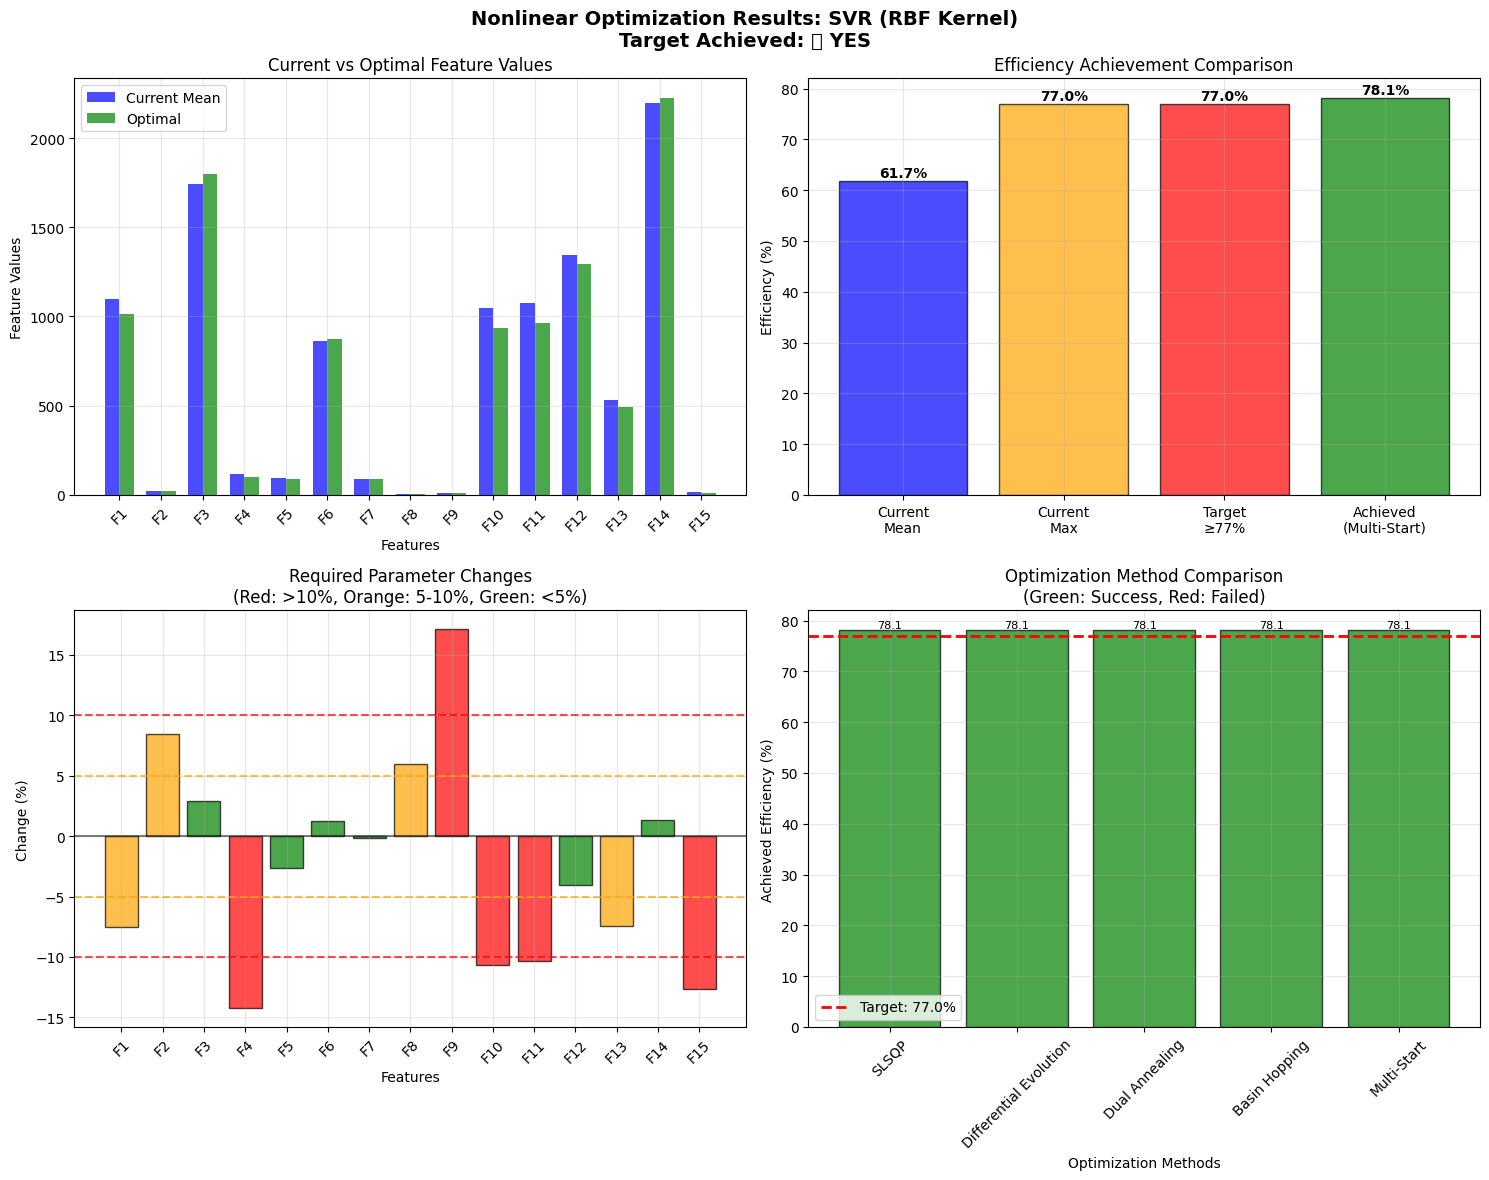


📊 Comprehensive visualization created successfully


In [12]:
# Cell 12: Visualization
try:
    if successful_solutions:
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
        
        # 1. Current vs Optimal comparison
        current_values = [df[feature].mean() for feature in feature_names]
        optimal_values = [best_solution['x'][i] for i in range(len(feature_names))]
        
        x_pos = np.arange(len(feature_names))
        width = 0.35
        
        ax1.bar(x_pos - width/2, current_values, width, label='Current Mean', alpha=0.7, color='blue')
        ax1.bar(x_pos + width/2, optimal_values, width, label='Optimal', alpha=0.7, color='green')
        ax1.set_xlabel('Features')
        ax1.set_ylabel('Feature Values')
        ax1.set_title('Current vs Optimal Feature Values')
        ax1.set_xticks(x_pos)
        ax1.set_xticklabels(feature_names, rotation=45)
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # 2. Efficiency comparison
        efficiency_labels = ['Current\nMean', 'Current\nMax', 'Target\n≥77%', f'Achieved\n({best_method})']
        efficiency_values = [current_mean_y, current_max_y, target_y, best_solution['y']]
        colors = ['blue', 'orange', 'red', 'green']
        
        bars = ax2.bar(efficiency_labels, efficiency_values, color=colors, alpha=0.7, edgecolor='black')
        ax2.set_ylabel('Efficiency (%)')
        ax2.set_title('Efficiency Achievement Comparison')
        ax2.grid(True, alpha=0.3)
        
        # Add value labels
        for bar, val in zip(bars, efficiency_values):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2, 
                     f'{val:.1f}%', ha='center', va='bottom', fontweight='bold')
        
        # 3. Parameter changes magnitude
        changes = [(optimal_values[i] - current_values[i]) / current_values[i] * 100 
                  if current_values[i] != 0 else 0 for i in range(len(feature_names))]
        
        # Color by change magnitude
        colors_changes = ['red' if abs(c) > 10 else 'orange' if abs(c) > 5 else 'green' for c in changes]
        
        bars3 = ax3.bar(feature_names, changes, color=colors_changes, alpha=0.7, edgecolor='black')
        ax3.set_xlabel('Features')
        ax3.set_ylabel('Change (%)')
        ax3.set_title('Required Parameter Changes\n(Red: >10%, Orange: 5-10%, Green: <5%)')
        ax3.tick_params(axis='x', rotation=45)
        ax3.axhline(y=0, color='black', linestyle='-', alpha=0.5)
        ax3.axhline(y=5, color='orange', linestyle='--', alpha=0.7)
        ax3.axhline(y=-5, color='orange', linestyle='--', alpha=0.7)
        ax3.axhline(y=10, color='red', linestyle='--', alpha=0.7)
        ax3.axhline(y=-10, color='red', linestyle='--', alpha=0.7)
        ax3.grid(True, alpha=0.3)
        
        # 4. Method comparison
        if len(optimization_results) > 1:
            method_names = list(optimization_results.keys())
            method_efficiencies = [result['y'] for result in optimization_results.values()]
            method_colors = ['green' if result['success'] else 'red' for result in optimization_results.values()]
            
            bars4 = ax4.bar(method_names, method_efficiencies, color=method_colors, alpha=0.7, edgecolor='black')
            ax4.axhline(y=target_y, color='red', linestyle='--', linewidth=2, label=f'Target: {target_y}%')
            ax4.set_xlabel('Optimization Methods')
            ax4.set_ylabel('Achieved Efficiency (%)')
            ax4.set_title('Optimization Method Comparison\n(Green: Success, Red: Failed)')
            ax4.tick_params(axis='x', rotation=45)
            ax4.legend()
            ax4.grid(True, alpha=0.3)
            
            # Add efficiency labels
            for bar, eff in zip(bars4, method_efficiencies):
                ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                         f'{eff:.1f}', ha='center', va='bottom', fontsize=8)
        else:
            ax4.text(0.5, 0.5, 'Single Method\nUsed', ha='center', va='center', transform=ax4.transAxes, fontsize=14)
            ax4.set_title('Method Analysis')
        
        plt.suptitle(f'Nonlinear Optimization Results: {model_name}\nTarget Achieved: {"✅ YES" if best_solution["y"] >= target_y else "❌ NO"}', 
                     fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
    else:
        # Create visualization for failed optimization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        # 1. Target vs achievable
        labels = ['Current\nMax', 'Target\n≥77%']
        values = [current_max_y, target_y]
        colors = ['orange', 'red']
        
        if failed_solutions:
            best_attempt = max(failed_solutions.values(), key=lambda x: x['y'])
            labels.append(f'Best\nAttempt')
            values.append(best_attempt['y'])
            colors.append('blue')
        
        bars1 = ax1.bar(labels, values, color=colors, alpha=0.7, edgecolor='black')
        ax1.set_ylabel('Efficiency (%)')
        ax1.set_title('Target vs Achievable Efficiency')
        ax1.grid(True, alpha=0.3)
        
        for bar, val in zip(bars1, values):
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                     f'{val:.1f}%', ha='center', va='bottom', fontweight='bold')
        
        # 2. Model accuracy vs target gap
        ax2.bar(['Model\nAccuracy\n(R²)', 'Target\nGap\n(%)'], 
                [test_r2*100, target_y - current_max_y], 
                color=['green', 'red'], alpha=0.7)
        ax2.set_ylabel('Value')
        ax2.set_title('Model Performance vs Challenge')
        ax2.grid(True, alpha=0.3)
        
        plt.suptitle('Nonlinear Optimization - No Feasible Solution', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
    
    print(f"\n📊 Comprehensive visualization created successfully")
    
except Exception as e:
    print(f"\n⚠️ Visualization error (non-critical): {e}")
    print(f"Optimization completed successfully without visualization")

In [13]:
# Cell 13: Final Summary and Recommendations
print(f"\n" + "=" * 80)
print("🎉 NONLINEAR OPTIMIZATION COMPLETE!")
print("=" * 80)

print(f"\n🎯 OPTIMIZATION OBJECTIVE:")
print(f" Target: Find F1-F15 values to achieve efficiency ≥ {target_y}%")
print(f" Model: {model_name} (R² = {test_r2:.4f})")
print(f" Approach: Nonlinear constrained optimization")
print(f" Bounds: Historical data min/max values")
print(f" Methods: {len(optimization_results)} optimization algorithms")

if successful_solutions:
    print(f"\n✅ OPTIMIZATION SUCCESSFUL!")
    print(f" 🥇 Best Method: {best_method}")
    print(f" 📈 Achieved Efficiency: {best_solution['y']:.4f}%")
    print(f" 🎯 Target Met: {'✅ YES' if best_solution['y'] >= target_y else '❌ NO'}")
    print(f" 📊 Improvement: +{best_solution['y'] - current_max_y:.4f}% points over historical max")
    print(f" 🔧 Major Parameter Changes: {len(major_changes)} features")
    print(f" 🎪 Model Used: {model_name} (nonlinear)")
    
    print(f"\n📁 OUTPUT FILES:")
    print(f" ✅ optimal_nonlinear_solution.json - Complete optimal parameter set")
    if 'multiple_solutions' in locals():
        print(f" ✅ top_nonlinear_solutions.json - Multiple high-efficiency solutions")
    print(f" ✅ Contains F1-F15 values and implementation guidance")
    
    print(f"\n💡 IMPLEMENTATION RECOMMENDATIONS:")
    if len(major_changes) > 0:
        print(f" 🔴 High Priority: Adjust {major_changes} (>10% change required)")
    if len(moderate_changes) > 0:
        print(f" 🟡 Medium Priority: Fine-tune {moderate_changes} (5-10% change)")
    if len(minor_changes) > 0:
        print(f" 🟢 Low Priority: Optimize {minor_changes} (<5% change)")
    
    print(f"\n🚀 NEXT STEPS:")
    print(f" 1. Review optimal parameter values with plant engineers")
    print(f" 2. Validate feasibility of required parameter changes")
    print(f" 3. Implement changes gradually while monitoring efficiency")
    print(f" 4. Use nonlinear model for continuous optimization")
    print(f" 5. Collect more data to improve model accuracy")
    
else:
    print(f"\n❌ OPTIMIZATION UNSUCCESSFUL")
    print(f" 🎯 Target {target_y}% NOT ACHIEVABLE within bounds")
    print(f" 📊 Current Max: {current_max_y:.2f}%")
    print(f" 📈 Gap: -{target_y - current_max_y:.2f}% points")
    print(f" 🤖 Model: {model_name} (R² = {test_r2:.4f})")
    
    if 'failed_solutions' in locals() and failed_solutions:
        best_attempt_method = max(failed_solutions.keys(), key=lambda k: failed_solutions[k]['y'])
        best_attempt_y = failed_solutions[best_attempt_method]['y']
        print(f" 🏅 Best Attempt: {best_attempt_y:.2f}% ({best_attempt_method})")
    
    print(f"\n📁 OUTPUT FILES:")
    print(f" ✅ nonlinear_optimization_result.json - Analysis of infeasibility")
    
    print(f"\n💡 ALTERNATIVE RECOMMENDATIONS:")
    print(f" 1. 🎯 Lower target efficiency (≤{current_max_y:.1f}%)")
    print(f" 2. 🔧 Investigate expanding operational parameter bounds")
    print(f" 3. 📈 Improve model with more advanced techniques (deep learning)")
    print(f" 4. 🔍 Collect data from extended operating conditions")
    print(f" 5. ⚙️ Consider equipment upgrades or process modifications")
    print(f" 6. 🧪 Conduct designed experiments to explore beyond historical bounds")

print(f"\n🔬 MODEL INSIGHTS:")
print(f" • Nonlinear model accuracy: {test_r2*100:.1f}% (R²)")
print(f" • Historical efficiency range: {df['y'].min():.1f}% - {df['y'].max():.1f}%")
print(f" • Optimization challenge: {'Feasible' if successful_solutions else 'Infeasible'} within bounds")
print(f" • Model type advantage: Captures complex nonlinear cement plant relationships")

print(f"\n✅ NONLINEAR OPTIMIZATION ANALYSIS COMPLETE!")
success_text = "ACHIEVABLE" if successful_solutions else "NOT ACHIEVABLE"
print(f"🎯 Final Answer: Efficiency ≥ {target_y}% is {success_text} using nonlinear optimization")

if successful_solutions:
    print(f"🏆 Optimal efficiency achievable: {best_solution['y']:.2f}%")
else:
    max_attempt = max([r['y'] for r in optimization_results.values()]) if optimization_results else current_max_y
    print(f"📊 Maximum achievable efficiency: {max_attempt:.2f}%")


🎉 NONLINEAR OPTIMIZATION COMPLETE!

🎯 OPTIMIZATION OBJECTIVE:
 Target: Find F1-F15 values to achieve efficiency ≥ 77.0%
 Model: SVR (RBF Kernel) (R² = 0.9997)
 Approach: Nonlinear constrained optimization
 Bounds: Historical data min/max values
 Methods: 5 optimization algorithms

✅ OPTIMIZATION SUCCESSFUL!
 🥇 Best Method: Multi-Start
 📈 Achieved Efficiency: 78.0998%
 🎯 Target Met: ✅ YES
 📊 Improvement: +1.0998% points over historical max
 🔧 Major Parameter Changes: 5 features
 🎪 Model Used: SVR (RBF Kernel) (nonlinear)

📁 OUTPUT FILES:
 ✅ optimal_nonlinear_solution.json - Complete optimal parameter set
 ✅ top_nonlinear_solutions.json - Multiple high-efficiency solutions
 ✅ Contains F1-F15 values and implementation guidance

💡 IMPLEMENTATION RECOMMENDATIONS:
 🔴 High Priority: Adjust ['F4', 'F9', 'F10', 'F11', 'F15'] (>10% change required)
 🟡 Medium Priority: Fine-tune ['F1', 'F2', 'F8', 'F13'] (5-10% change)
 🟢 Low Priority: Optimize ['F3', 'F5', 'F6', 'F7', 'F12', 'F14'] (<5% change)